In [359]:
import sys
sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")
#sys.path.insert(0, r'/home/pirwin/Git/HelperPI')
import itertools
import HelperPI
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sts
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score, matthews_corrcoef, make_scorer, classification_report
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [356]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [2]:
helper = HelperPI.Helper()

INFO:root:Initializing...


In [3]:
#sql = helper.getSQL(r"C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\TAB_MODELING.sql")

In [4]:
#base, dtypesdf = helper.readData(sql)
base = pd.read_csv(r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\tab_model.csv', parse_dates=['DATE_VALUE'])
#base = pd.read_csv(r'/home/pirwin/Git/IPy_Notebooks/SQL/tab_model.csv',parse_dates=['DATE_VALUE'])
base['DAYS_BTW_PURCH'] = base['DAYS_AS_CUSTOMER']/base['TOTAL_TRANSACTIONS']
dtypes = helper.getDtypes(base)

INFO:root:Getting data types...


                  Count     Column Type
0            DATE_VALUE  datetime64[ns]
1                RECORD          object
2            MEDHINC_CY         float64
3             MEDAGE_CY         float64
4            CLOSEST_BP         float64
5           CLOSEST_CAB         float64
6     MALES_IN_HOUSHOLD           int64
7   FEMALES_IN_HOUSHOLD           int64
8      REWARDS_CUSTOMER           int64
9      DAYS_AS_CUSTOMER           int64
10   TOTAL_TRANSACTIONS           int64
11     REW_TRANSACTIONS           int64
12          TOTAL_SPEND         float64
13  DAYS_SINCE_PURCHASE           int64
14     TARGET_VALUE12MO         float64
15  TARGET_PURCH_NEXT15           int64
16       DAYS_BTW_PURCH         float64


### Imputing missing then Splitting the data for train and test using helper application

In [247]:
collist = ['MEDHINC_CY','MEDAGE_CY','CLOSEST_BP','MALES_IN_HOUSHOLD','FEMALES_IN_HOUSHOLD','REWARDS_CUSTOMER',
          'DAYS_AS_CUSTOMER','TOTAL_TRANSACTIONS','REW_TRANSACTIONS','TOTAL_SPEND','DAYS_SINCE_PURCHASE',
          'DAYS_BTW_PURCH']
X = base[collist]
y = base['TARGET_PURCH_NEXT15']


### Determination of missing values

In [248]:
missing_df = X.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / X.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.01]

column_name  missing_count  missing_ratio
0  MEDHINC_CY           3792        0.03792
1   MEDAGE_CY           3792        0.03792

MEDHINC_CY Coef: -0.01  pval:  0.1072
MEDAGE_CY Coef: 0.03  pval:  0.0000
CLOSEST_BP Coef: -0.01  pval:  0.0001
MALES_IN_HOUSHOLD Coef: 0.18  pval:  0.0000
FEMALES_IN_HOUSHOLD Coef: 0.04  pval:  0.0000
REWARDS_CUSTOMER Coef: 0.34  pval:  0.0000
DAYS_AS_CUSTOMER Coef: 0.06  pval:  0.0000
TOTAL_TRANSACTIONS Coef: 0.30  pval:  0.0000
REW_TRANSACTIONS Coef: 0.27  pval:  0.0000
TOTAL_SPEND Coef: 0.36  pval:  0.0000
DAYS_SINCE_PURCHASE Coef: -0.38  pval:  0.0000
DAYS_BTW_PURCH Coef: -0.34  pval:  0.0000


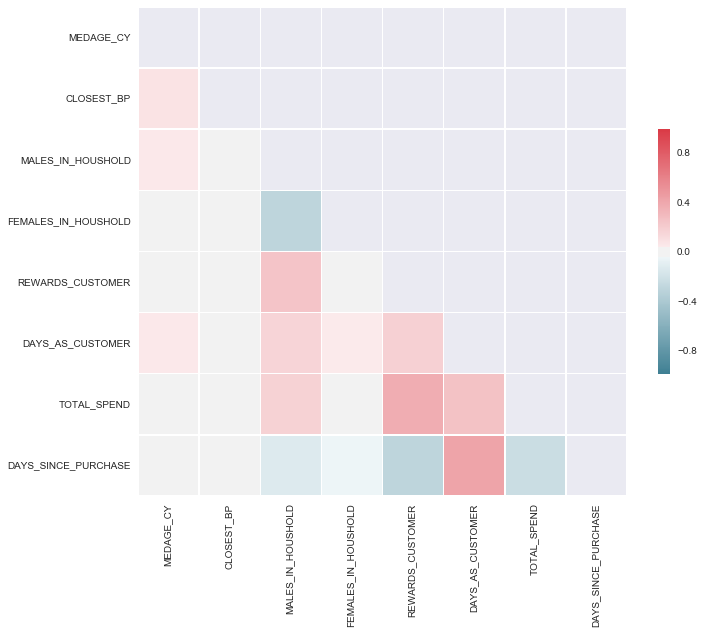

In [249]:

imr = Imputer(missing_values='NaN',strategy='median',axis=0)
imr = imr.fit(X)
imputed_data = pd.DataFrame(imr.transform(X.values), columns = collist)

for var in collist:
    coef, pval = stats.pearsonr(imputed_data[var].as_matrix(), y.as_matrix())
    
    print(var + ' Coef: %.2f  pval:  %.4f' % (coef, pval))


collist2 = ['MEDAGE_CY','CLOSEST_BP','MALES_IN_HOUSHOLD','FEMALES_IN_HOUSHOLD','REWARDS_CUSTOMER',
          'DAYS_AS_CUSTOMER','TOTAL_SPEND','DAYS_SINCE_PURCHASE']

imputed_data2 = imputed_data[collist2]
    
corr = imputed_data2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.99, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


    



In [8]:
train_X, test_X, train_y, test_y = helper.splitData2(imputed_data2, y, 0.5)

train_X = pd.DataFrame(train_X, columns=collist2)
test_X = pd.DataFrame(test_X, columns=collist2)

In [9]:
train_X.head()

MEDAGE_CY  CLOSEST_BP  MALES_IN_HOUSHOLD  FEMALES_IN_HOUSHOLD  \
24341       40.0        3.99                0.0                  1.0   
67534       42.0        8.99                1.0                  0.0   
35080       47.0       64.42                0.0                  0.0   
4828        42.0       11.81                0.0                  0.0   
59259       43.0       92.59                1.0                  0.0   

       REWARDS_CUSTOMER  DAYS_AS_CUSTOMER  TOTAL_SPEND  DAYS_SINCE_PURCHASE  
24341               1.0            1045.0       104.94                726.0  
67534               1.0            3747.0      1397.47                199.0  
35080               0.0            1655.0       233.75               1166.0  
4828                0.0             945.0       144.19                 92.0  
59259               1.0            2668.0       870.94               2005.0

In [11]:
#sns.pairplot(train_X)
#sns.plt.savefig('Scattermatrix.png')
#plt.show()

In [136]:

stdsc = StandardScaler()
train_X_std = pd.DataFrame(stdsc.fit_transform(train_X), columns=collist2)
test_X_std = pd.DataFrame(stdsc.fit_transform(test_X), columns=collist2)

sm = SMOTE(random_state=123, ratio=1.0)
train_X_std_res, train_y_res = sm.fit_sample(train_X_std, train_y)

#train_X_std_res = pd.DataFrame(train_X_std_res, columns = collist2)
#train_y_res = pd.DataFrame(train_y_res)

#sns.pairplot(train_X_std)
#sns.plt.savefig('Scattermatrix.png')
#plt.show()

INFO:imblearn.base:Compute classes statistics ...
INFO:imblearn.base:2 classes detected: Counter({0: 40542, 1: 9458})
INFO:imblearn.base:Generated 31084 new samples ...


In [180]:
sum(train_y), len(train_y)
print()

(9458, 50000)

In [181]:
sum(test_y), len(test_y)

(9471, 50000)

 1) DAYS_SINCE_PURCHASE            0.344017
 2) TOTAL_SPEND                    0.211120
 3) DAYS_AS_CUSTOMER               0.126991
 4) CLOSEST_BP                     0.112925
 5) MEDAGE_CY                      0.103562
 6) REWARDS_CUSTOMER               0.060074
 7) MALES_IN_HOUSHOLD              0.025860
 8) FEMALES_IN_HOUSHOLD            0.015451


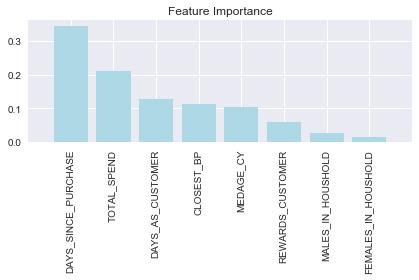

In [139]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = np.asarray(collist2)

forests = RandomForestClassifier(n_estimators=100,
                                random_state=0,
                                n_jobs=-1)
forests.fit(train_X_std_res, train_y_res)
importances = forests.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(train_X_std_res.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]],
                                      importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(train_X_std_res.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(train_X_std_res.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, train_X_std_res.shape[1]])
plt.tight_layout()
plt.show()

### Parameter Tuning Version

In [11]:
def modelfit(alg, dtrain, dlabels, feature_names, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=dlabels.values, feature_names = feature_names)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])

    alg.fit(dtrain, dlabels, eval_metric='auc')

    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dlabels.values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dlabels.values, dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    
    


Model Report
Accuracy : 0.872
AUC Score (Train): 0.892034


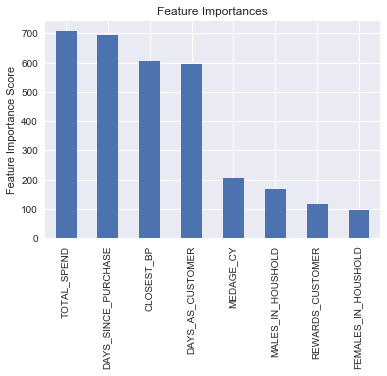

In [13]:
xgb1 = xgb.XGBClassifier(
    learning_rate = 0.07,
    n_estimators = 1000,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    seed = 27)

modelfit(xgb1, train_X_std, train_y, collist2)

In [14]:
auc_weighted = make_scorer(roc_auc_score, average='weighted')
auc_weighted

make_scorer(roc_auc_score, average=weighted)

In [73]:
param_test1 = {
    'max_depth':list(range(3,10,2)),
    'min_child_weight':list(range(1,6,2))
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test1, scoring='f1', iid=False, cv=5)

gsearch1.fit(train_X_std_res, train_y_res)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.84072, std: 0.04001, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83988, std: 0.04069, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.84160, std: 0.03939, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.85552, std: 0.06262, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.85496, std: 0.06213, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.85492, std: 0.06199, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.86032, std: 0.06990, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.86028, std: 0.06986, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.85968, std: 0.07068, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.86516, std: 0.07435, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.86479, std: 0.07454, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.86413, std: 0.07347, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_child_weight': 1

In [76]:
# max_depth = 9
# min_child_weight = 1

param_test2 = {
    'min_child_weight':[1,2,3],
    'max_depth':[8,9,10]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
     min_child_weight=1, gamma=0.0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test2, scoring ='f1', iid=False, cv=5)

gsearch2.fit(train_X_std_res, train_y_res)

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86277, std: 0.07228, params: {'max_depth': 8, 'min_child_weight': 1},
  mean: 0.86231, std: 0.07269, params: {'max_depth': 8, 'min_child_weight': 2},
  mean: 0.86245, std: 0.07206, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: 0.86516, std: 0.07435, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.86422, std: 0.07353, params: {'max_depth': 9, 'min_child_weight': 2},
  mean: 0.86479, std: 0.07454, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.86843, std: 0.07386, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: 0.86797, std: 0.07301, params: {'max_depth': 10, 'min_child_weight': 2},
  mean: 0.86649, std: 0.07416, params: {'max_depth': 10, 'min_child_weight': 3}],
 {'max_depth': 10, 'min_child_weight': 1},
 0.86843314923125481)

In [77]:
#max_depth = 10
#min_child_weight = 1

param_test3 = {
    'gamma':[i/10.0 for i in range(0, 5)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=10,
     min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test3, scoring = 'f1', iid=False, cv=5)

gsearch3.fit(train_X_std_res, train_y_res)

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86843, std: 0.07386, params: {'gamma': 0.0},
  mean: 0.86826, std: 0.07282, params: {'gamma': 0.1},
  mean: 0.86824, std: 0.07344, params: {'gamma': 0.2},
  mean: 0.86750, std: 0.07376, params: {'gamma': 0.3},
  mean: 0.86766, std: 0.07419, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.86843314923125481)

In [79]:
xgb2 = xgb.XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 300,
    max_depth = 10,
    min_child_weight = 1,
    gamma = 0.0,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    seed = 27)

modelfit(xgb2, train_X_std_res, train_y_res, collist2)




AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [80]:
#max_depth = 10
#min_child_weight = 1
#gamma = 0.0

param_test4 = {
    'subsample':[i/10.0 for i in range(3, 10)],
    'colsample_bytree':[i/10.0 for i in range(4, 10)]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=10,
     min_child_weight=1, gamma=0.0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', scale_pos_weight=1, seed=27),
     param_grid = param_test4, scoring = 'f1', iid=False, cv=5)

gsearch4.fit(train_X_std_res, train_y_res)

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85705, std: 0.07132, params: {'colsample_bytree': 0.4, 'subsample': 0.3},
  mean: 0.85994, std: 0.07169, params: {'colsample_bytree': 0.4, 'subsample': 0.4},
  mean: 0.86202, std: 0.07300, params: {'colsample_bytree': 0.4, 'subsample': 0.5},
  mean: 0.86169, std: 0.07272, params: {'colsample_bytree': 0.4, 'subsample': 0.6},
  mean: 0.86182, std: 0.07408, params: {'colsample_bytree': 0.4, 'subsample': 0.7},
  mean: 0.86130, std: 0.07482, params: {'colsample_bytree': 0.4, 'subsample': 0.8},
  mean: 0.86219, std: 0.07406, params: {'colsample_bytree': 0.4, 'subsample': 0.9},
  mean: 0.86186, std: 0.06953, params: {'colsample_bytree': 0.5, 'subsample': 0.3},
  mean: 0.86262, std: 0.07264, params: {'colsample_bytree': 0.5, 'subsample': 0.4},
  mean: 0.86485, std: 0.07354, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
  mean: 0.86545, std: 0.07182, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
  mean: 0.86607, std: 0.07286, params: {'colsample_bytree': 0.5, 'subsample'

In [81]:
#max_depth = 10
#min_child_weight = 1
#gamma = 0.0
#subsample = 0.9
#colsample_bytree = 0.9

param_test5 = {

    'colsample_bytree':[i/100.0 for i in range(85, 100, 5)],
    'subsample':[i/100 for i in range(85,100,5)]
}

gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=10,
     min_child_weight=1, gamma=0.0, subsample=0.9, colsample_bytree=0.9,
     objective= 'binary:logistic', scale_pos_weight=1, seed=27),
     param_grid = param_test5, scoring = 'f1', iid=False, cv=5)

gsearch5.fit(train_X_std_res, train_y_res)

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87029, std: 0.07408, params: {'colsample_bytree': 0.85, 'subsample': 0.85},
  mean: 0.87027, std: 0.07528, params: {'colsample_bytree': 0.85, 'subsample': 0.9},
  mean: 0.87001, std: 0.07328, params: {'colsample_bytree': 0.85, 'subsample': 0.95},
  mean: 0.87072, std: 0.07339, params: {'colsample_bytree': 0.9, 'subsample': 0.85},
  mean: 0.87229, std: 0.07199, params: {'colsample_bytree': 0.9, 'subsample': 0.9},
  mean: 0.87137, std: 0.07135, params: {'colsample_bytree': 0.9, 'subsample': 0.95},
  mean: 0.87072, std: 0.07339, params: {'colsample_bytree': 0.95, 'subsample': 0.85},
  mean: 0.87229, std: 0.07199, params: {'colsample_bytree': 0.95, 'subsample': 0.9},
  mean: 0.87137, std: 0.07135, params: {'colsample_bytree': 0.95, 'subsample': 0.95}],
 {'colsample_bytree': 0.9, 'subsample': 0.9},
 0.87229350759366864)

In [82]:
#max_depth = 10
#min_child_weight = 1
#gamma = 0.0
#subsample = 0.9
#colsample_bytree = 0.9

param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=10,
     min_child_weight=1, gamma=0.0, subsample=0.9, colsample_bytree=0.9,
     objective= 'binary:logistic', scale_pos_weight=1, seed=27),
     param_grid = param_test6, scoring = 'f1', iid=False, cv=5)

gsearch6.fit(train_X_std_res, train_y_res)

gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87229, std: 0.07199, params: {'reg_alpha': 1e-05},
  mean: 0.87193, std: 0.07205, params: {'reg_alpha': 0.01},
  mean: 0.87150, std: 0.07267, params: {'reg_alpha': 0.1},
  mean: 0.87183, std: 0.07269, params: {'reg_alpha': 1},
  mean: 0.83543, std: 0.04380, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.87229350759366864)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Accuracy : 0.9242
AUC Score (Train): 0.981425


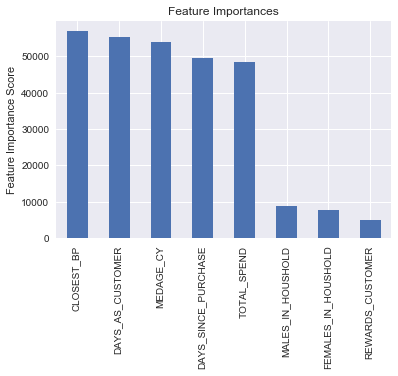

In [140]:
xgb3 = xgb.XGBClassifier(
    learning_rate = 0.01,
    n_estimators = 1000,
    max_depth = 10,
    min_child_weight = 1,
    gamma = 0.0,
    subsample = 0.9,
    colsample_bytree = 0.9,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    reg_alpha=1e-05,
    seed = 27)

modelfit(xgb3, pd.DataFrame(train_X_std_res, columns=collist2), pd.DataFrame(train_y_res), collist2)

In [146]:

tuned_model = xgb.XGBClassifier(learning_rate = 0.01,
                        n_estimators = 1000,
                        max_depth = 10,
                        min_child_weight = 1,
                        gamma = 0.0,
                        subsample = 0.9,
                        colsample_bytree = 0.9,
                        objective = 'binary:logistic',
                        scale_pos_weight = 1,
                        reg_alpha=1e-05,
                        seed = 27)
xgbmodel = tuned_model.fit(train_X_std_res, train_y_res, 
                 eval_set=[(train_X_std_res, train_y_res), (test_X_std.values, test_y)], 
                 eval_metric='auc',
                 early_stopping_rounds=50,                 
                 verbose=True)

#fig, ax = plt.subplots(figsize=(12,18))
#xgb.plot_importance(xgbmodel, height=0.8, ax=ax)
#plt.show()

[0]	validation_0-auc:0.901281	validation_1-auc:0.850003
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.907853	validation_1-auc:0.855331
[2]	validation_0-auc:0.911124	validation_1-auc:0.856749
[3]	validation_0-auc:0.912817	validation_1-auc:0.856796
[4]	validation_0-auc:0.913229	validation_1-auc:0.857402
[5]	validation_0-auc:0.916808	validation_1-auc:0.857674
[6]	validation_0-auc:0.916906	validation_1-auc:0.85854
[7]	validation_0-auc:0.917916	validation_1-auc:0.857318
[8]	validation_0-auc:0.918086	validation_1-auc:0.858591
[9]	validation_0-auc:0.918002	validation_1-auc:0.858629
[10]	validation_0-auc:0.918115	validation_1-auc:0.859722
[11]	validation_0-auc:0.918159	validation_1-auc:0.859945
[12]	validation_0-auc:0.918318	validation_1-auc:0.86085
[13]	validation_0-auc:0.919427	validation_1-auc:0.861181
[14]	validation_0-auc:0.920166	validation_1-auc:0.860789


Accuracy: 77.97%


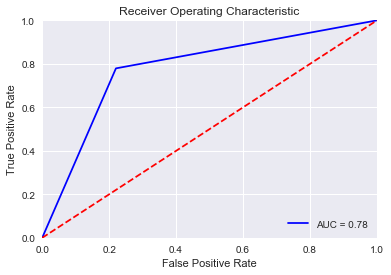

In [147]:
pred_y = xgbmodel.predict(test_X_std.values)

accuracy = accuracy_score(test_y, pred_y)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(test_y, pred_y)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###  Alternate Parameter tuning - only for fast running algorithms

In [148]:

tuned_parameters = [{
    'C': [100, 10, 1, .1, .01, .001],
    'dual':[False]
}]

scores = ['recall_weighted']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LinearSVC(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(train_X_std_res, train_y_res)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_y, clf.predict(test_X_std)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for recall_weighted

Best parameters set found on development set:

{'C': 0.1, 'dual': False}

Grid scores on development set:

0.785 (+/-0.003) for {'C': 100, 'dual': False}
0.785 (+/-0.003) for {'C': 10, 'dual': False}
0.785 (+/-0.003) for {'C': 1, 'dual': False}
0.785 (+/-0.003) for {'C': 0.1, 'dual': False}
0.785 (+/-0.003) for {'C': 0.01, 'dual': False}
0.785 (+/-0.003) for {'C': 0.001, 'dual': False}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.94      0.76      0.84     40529
          1       0.44      0.80      0.56      9471

avg / total       0.85      0.77      0.79     50000




             precision    recall  f1-score   support

          0       0.94      0.77      0.85     40529
          1       0.44      0.79      0.57      9471

avg / total       0.85      0.77      0.79     50000

Accuracy: 77.33%


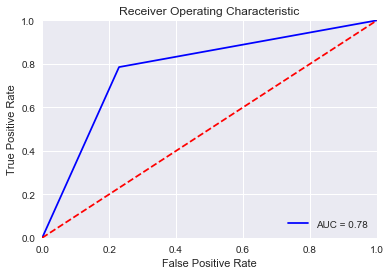

In [107]:
svm = LinearSVC(C=.1,dual=False)

clf = CalibratedClassifierCV(svm, method='sigmoid', cv=5)

svcmodel = clf.fit(train_X_std_res, train_y_res)

print(classification_report(test_y, svcmodel.predict(test_X_std)))


# evaluate predictions
accuracy = accuracy_score(test_y, svcmodel.predict(test_X_std))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(test_y, svcmodel.predict(test_X_std))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [150]:
tuned_parameters = [{
    'C': [100, 10, 1, .1, .01, .001],
    'dual':[False]
}]

scores = ['recall_weighted']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(train_X_std_res, train_y_res)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_y, clf.predict(test_X_std)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for recall_weighted

Best parameters set found on development set:

{'C': 1, 'dual': False}

Grid scores on development set:

0.790 (+/-0.004) for {'C': 100, 'dual': False}
0.790 (+/-0.004) for {'C': 10, 'dual': False}
0.790 (+/-0.004) for {'C': 1, 'dual': False}
0.790 (+/-0.004) for {'C': 0.1, 'dual': False}
0.790 (+/-0.004) for {'C': 0.01, 'dual': False}
0.785 (+/-0.002) for {'C': 0.001, 'dual': False}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.94      0.77      0.84     40529
          1       0.44      0.80      0.57      9471

avg / total       0.85      0.77      0.79     50000




             precision    recall  f1-score   support

          0       0.94      0.77      0.84     40529
          1       0.44      0.80      0.57      9471

avg / total       0.85      0.77      0.79     50000

Accuracy: 77.22%


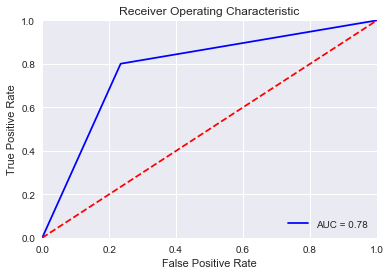

In [151]:

log = LogisticRegression(C=1,dual=False)

logmodel = log.fit(train_X_std_res, train_y_res)

print(classification_report(test_y, logmodel.predict(test_X_std.values)))


# evaluate predictions
accuracy = accuracy_score(test_y,logmodel.predict(test_X_std.values))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(test_y, logmodel.predict(test_X_std.values))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

['C:\\users\\pairwin\\Documents\\GitHub\\IPy_Notebooks\\Analyses\\tabmodel_impute.pkl']

In [198]:
svcpred = svcmodel.predict(train_X_std_res)
xgbpred = xgbmodel.predict(train_X_std_res)
logpred = logmodel.predict(train_X_std_res)
resarray = np.array([train_y_res, svcpred, xgbpred, logpred], np.int32)

svc_test = svcmodel.predict(test_X_std.values)
xgb_test = xgbmodel.predict(test_X_std.values)
log_test = logmodel.predict(test_X_std.values)
res_test = np.array([test_y, svc_test, xgb_test, log_test], np.int32)

result = pd.DataFrame(resarray.transpose(), columns = ['true_y','svcpred','xgbpred','logpred'])
result_test = pd.DataFrame(res_test.transpose(), columns = ['true_y','svcpred','xgbpred','logpred'])
len(result), len(result_test)

(81084, 50000)

In [204]:
result_test.corr()

true_y   svcpred   xgbpred   logpred
true_y   1.000000  0.461406  0.467229  0.467843
svcpred  0.461406  1.000000  0.736469  0.936895
xgbpred  0.467229  0.736469  1.000000  0.764162
logpred  0.467843  0.936895  0.764162  1.000000

In [193]:
len(svcpred), len(xgbpred), len(logpred), len(train_y_res)


(81084, 81084, 81084, 81084)

In [196]:
len(svc_test), len(xgb_test), len(log_test), len(test_y)

(50000, 50000, 50000, 50000)

In [199]:
ensemble = LogisticRegression(C=1, dual=False)
ensemble.fit(result[['svcpred','xgbpred','logpred']].values, result[['true_y']].values)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [200]:
result.corr()

true_y   svcpred   xgbpred   logpred
true_y   1.000000  0.571013  0.713594  0.580690
svcpred  0.571013  1.000000  0.784586  0.947088
xgbpred  0.713594  0.784586  1.000000  0.806292
logpred  0.580690  0.947088  0.806292  1.000000

Accuracy: 77.97%
             precision    recall  f1-score   support

          0       0.94      0.78      0.85     40529
          1       0.45      0.78      0.57      9471

avg / total       0.85      0.78      0.80     50000



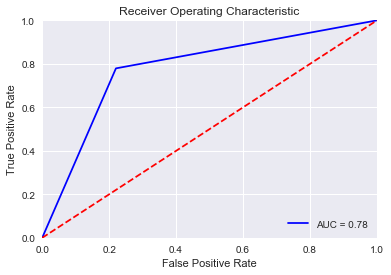

In [201]:
# evaluate predictions
accuracy = accuracy_score(result_test['true_y'].values, ensemble.predict(result_test[['svcpred','xgbpred','logpred']].values))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

print(classification_report(result_test['true_y'].values, ensemble.predict(result_test[['svcpred','xgbpred','logpred']].values)))

fpr, tpr, _ = roc_curve(result_test['true_y'].values, ensemble.predict(result_test[['svcpred','xgbpred','logpred']].values))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [203]:
confusion_matrix(result_test['true_y'].values, ensemble.predict(result_test[['svcpred','xgbpred','logpred']].values))


array([[31603,  8926],
       [ 2091,  7380]])

In [361]:
joblib.dump(svcmodel, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\tabmodelsvc.pkl')
joblib.dump(xgbmodel, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\tabmodelxgb.pkl')
joblib.dump(logmodel, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\tabmodellog.pkl')
joblib.dump(ensemble, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\tabmodelensemble.pkl')
joblib.dump(imr, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\tabmodel_impute.pkl')

['C:\\users\\pairwin\\Documents\\GitHub\\IPy_Notebooks\\Analyses\\tabmodel_impute.pkl']

In [346]:
np.random.seed(0)

n_folds = 10
verbose = True
shuffle = False

scaled_data = stdsc.fit_transform(imputed_data2)

X2, hold_X, y2, hold_y = helper.splitData2(scaled_data, np.array(y), 0.2)

sm = SMOTE(random_state=123, ratio=1.0)
X2_res, y2_res = sm.fit_sample(X2, y2)


skf = StratifiedKFold(n_folds)
print(len(X2_res), len(hold_X), len(y2_res), len(hold_y))
print(type(X2_res), type(hold_X), type(y2_res), type(hold_y))

INFO:imblearn.base:Compute classes statistics ...
INFO:imblearn.base:2 classes detected: Counter({0: 64814, 1: 15186})
INFO:imblearn.base:Generated 49628 new samples ...


129628 20000 129628 20000
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [353]:
svm = LinearSVC(C=.1,dual=False)

clfs = [RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
        RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
        xgb.XGBClassifier(n_estimators=100, objective='binary:logistic'),
        CalibratedClassifierCV(svm, cv=3, method='sigmoid'),
        LogisticRegression(C=0.1, dual=False, random_state=0)]
        

In [354]:
dataset_blend_train = np.zeros((X2_res.shape[0], len(clfs)))
dataset_blend_test = np.zeros((hold_X.shape[0], len(clfs)))
dataset_blend_train.shape, dataset_blend_test.shape

((129628, 7), (20000, 7))

In [355]:
for j, clf in enumerate(clfs):
    print(j, clf)
    dataset_blend_test_j = np.zeros((hold_X.shape[0], skf.get_n_splits()))
    fold = 0
    for train, test in skf.split(X2_res, y2_res):        
        print("Fold: " + str(fold))
        X_train = X2_res[train]
        y_train = y2_res[train]
        X_test = X2_res[test]
        y_test = y2_res[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, fold] = clf.predict_proba(hold_X)[:, 1]
        dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
        fold += 1
        

        
    print()
    print("Blending.")
    clf = LogisticRegression()
    clf.fit(dataset_blend_train, y2_res)
    y_submission = clf.predict_proba(dataset_blend_test)[:, 1]
    

0 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9

Blending.
1 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9

Blending.
2 ExtraTreesClassifier(bootstrap=False, c

In [350]:
def decide(prob):
    if prob >= .5:
        return 1
    else:
        return 0


0.78293608650564062

Confusion matrix, without normalization
[[14599  1658]
 [ 1511  2232]]


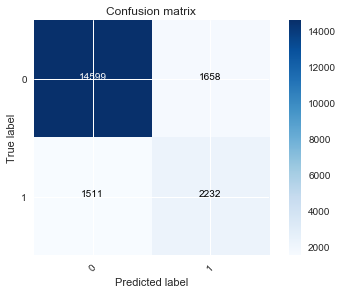

In [360]:
roc_auc_score(hold_y, np.array([decide(yi) for yi in y_submission]))
cm = confusion_matrix(hold_y, np.array([decide(yi) for yi in y_submission]))
plot_confusion_matrix(cm, ['0', '1'])